In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [4]:
#update to user path
sphere_hm=np.load('C:/Users/vik16/OneDrive/Documents/Baillet Lab/data_from_malte/' +\
                          'eeg_dipole_fields_sphere_model.npz')
sphere_hm['elements']

array([[315357, 339966, 350794, 365999],
       [324469, 348353, 341183, 428538],
       [337094, 322704, 365809, 384305],
       ...,
       [308256, 307708, 308473, 785988],
       [304982, 305218, 306116, 785833],
       [310202, 309084, 309327, 785832]], dtype=uint64)

In [6]:
real_hm=np.load('C:/Users/vik16/OneDrive/Documents/Baillet Lab/data_from_malte/' +\
                          'eeg_dipole_fields_realistic_model.npz')
print(real_hm['nodes'].shape)
print(real_hm['elements'].shape)
print(real_hm['dipole_position'], real_hm['dipole_moment'])

(885214, 3)
(5335615, 4)
[29.8845925 40.42975   98.4013575] [ 1.8532310e-05 -7.4484224e-06  1.0365742e-06]


In [4]:
real_hm['conductivities']

array([4.650e-04, 8.000e-06, 2.500e-05, 1.654e-03, 2.750e-04, 1.260e-04])

In [11]:
real_hm['label_info']

array([(0, 'Scalp'), (1, 'Compacta'), (2, 'Spongiosa'), (3, 'CSF'),
       (4, 'GM'), (5, 'WM')], dtype=[('label', '<i4'), ('tissue', '<U9')])

In [4]:
real_hm['current_density'].shape

NameError: name 'real_hm' is not defined

In [8]:
three_layer_hm = np.load('C:/Users/vik16/OneDrive/Documents/Baillet Lab/data_from_malte/' +\
                        'dipole_simulation_results_sep.npz')

In [6]:
three_layer_hm['conductivities']

array([0.33  , 0.0042, 0.33  ])

In [ ]:
print(max(real_hm['nodes'].flatten()))
print(real_hm['conductivities'])
print(real_hm['label_info'])
print(real_hm['conductivities'][4])

In [15]:
real_hm['label_info']

array([(0, 'Scalp'), (1, 'Compacta'), (2, 'Spongiosa'), (3, 'CSF'),
       (4, 'GM'), (5, 'WM')], dtype=[('label', '<i4'), ('tissue', '<U9')])

In [27]:
real_hm['electric_fields']

array([[-3.26505466e-08, -2.19426106e-07, -1.81763321e-07],
       [-1.22653516e-07, -3.95844292e-07, -2.54085513e-07],
       [-2.15535830e-08, -2.16812965e-07, -2.02917384e-07],
       ...,
       [-7.47110432e-11,  1.15974517e-10, -4.22815553e-11],
       [-7.23135851e-11,  3.36475975e-10, -8.55375659e-11],
       [-7.62757425e-11,  1.20464833e-10, -3.50215470e-11]])

In [37]:
len(np.sum(real_hm['electric_fields'] * real_hm['electric_fields'], axis=1))

5335615

In [14]:
#Load in summed secondary currents for subject 2
summed_sec_hm=np.load("C:/Users/vik16/OneDrive/Documents/Baillet Lab/data_from_malte/summed_sec_curr_sub0002.npz")

## Part 1: Power Calculation
Find the power at each element:
1. Find the volume at each element
2. Find the secondary current at each element
3. Find the resistivity of each element

In [19]:
def calc_tetr_vol_from_vert(v_list):
    """"
    Input: ordered triplets (np array) of 3D FEM vertex coordinates (in mm)
    Output: volume of tetrahedral element

    """
    
    a = v_list.T
    b = np.row_stack((a,[1,1,1,1]))
    #figure out a clever numerical computation to parallelize this
    vol = 1.0/6.0*np.abs(np.linalg.det(b))
    return vol

In [20]:
def calculate_fem_p(head_model):
    num_elements = head_model['elements'].shape[0]
    p_els = np.zeros(num_elements)
    v_els = np.zeros(num_elements) #are these uniform? or do I need to compute for each element?
    i_sq_els = np.zeros(num_elements)
    start = time.perf_counter()
    
    all_el_vs = head_model['elements']
    all_el_xyz = np.array(head_model['nodes'])[all_el_vs, :]
    
    v_els = [calc_tetr_vol_from_vert(all_el_xyz[i]) for i in range(num_elements)]
   
        
    conds = np.array(head_model['conductivities'][head_model['labels']])#conductivity
    i_sq_els = np.linalg.norm(head_model['current_density'], axis=1)**2
    p_els = i_sq_els*v_els/conds #FIXED
    stop = time.perf_counter()
    time_elapsed = stop - start
    print("Time elapsed:", time_elapsed)
    return v_els, i_sq_els, p_els

In [ ]:
head_model['current_density']

In [21]:
def calculate_fem_p_from_efield(head_model):
    num_elements = head_model['elements'].shape[0]
    p_els = np.zeros(num_elements)
    v_els = np.zeros(num_elements) #are these uniform? or do I need to compute for each element?
    i_sq_els = np.zeros(num_elements)
    start = time.perf_counter()
    
    all_el_vs = head_model['elements']
    all_el_xyz = np.array(head_model['nodes'])[all_el_vs, :]
    
    v_els = [calc_tetr_vol_from_vert(all_el_xyz[i]) for i in range(num_elements)]
   
        
    conds = np.array(head_model['conductivities'][head_model['labels']])#conductivity
    e_dot_e = np.sum(head_model['electric_fields'] * head_model['electric_fields'], axis=1)
    cond_e_dot_e = conds*e_dot_e*v_els
    #p_els = i_sq_els/(v_els*conds)  #ERROR IN DERIVATION
    p_els = conds*e_dot_e #FIXED
    stop = time.perf_counter()
    time_elapsed = stop - start
    print("Time elapsed:", time_elapsed)
    return p_els

In [7]:
p_output = calculate_fem_p(real_hm)

Time elapsed: 204.83827850000003


In [8]:
real_v_els = p_output[0]
real_i_sq_els = p_output[1]
real_p_els = p_output[2]


In [9]:
print("Total Power in Realistic FEM Head Model (in W):", sum(real_p_els))

Total Power in Realistic FEM Head Model (in W): 8.126895999241072e-08


In [39]:
p_output_efield = calculate_fem_p_from_efield(real_hm)

Time elapsed: 220.51286720000007


In [46]:
real_p_efield = p_output_efield
print("Total Power in Realistic FEM Head Model (in W) by volume int of <E, sigma*E>:", sum(real_p_efield))

Total Power in Realistic FEM Head Model (in W) by volume int of <E, sigma*E>: 1.2680310264953684e-07


In [10]:
p_output = calculate_fem_p(sphere_hm)

Time elapsed: 186.1089316


In [11]:
sphere_v_els = p_output[0]
sphere_i_sq_els = p_output[1]
sphere_p_els = p_output[2]


In [12]:
print("Total Power in Spherical FEM Head Model (in W):", sum(sphere_p_els))

Total Power in Spherical FEM Head Model (in W): 64.91533962421946


In [13]:
sphere_gm_indices = np.where(sphere_hm['labels'] == 3)[0]
real_gm_indices = np.where(real_hm['labels'] == 4)[0]
print("Gray matter secondary P in spherical head model (W):", sum(sphere_p_els[sphere_gm_indices]))
print("Gray matter secondary P in realistic head model (W):", sum(real_p_els[real_gm_indices]))

Gray matter secondary P in spherical head model (W): 50.52659353928916
Gray matter secondary P in realistic head model (W): 7.785184637502724e-08


In [22]:
p_output = calculate_fem_p(three_layer_hm)

Time elapsed: 11.966809999999896


In [23]:
tl_v_els = p_output[0]
tl_i_sq_els = p_output[1]
tl_p_els = p_output[2]

In [17]:
#Repeat for summed secondary currents
p_output = calculate_fem_p(summed_sec_hm)
ss_v_els = p_output[0]
ss_i_sq_els = p_output[1]
ss_p_els = p_output[2]

Time elapsed: 6.015166800000031


In [18]:
sum(ss_p_els)

2.3255543171097833e-11

## Part 2: Current Dipole/Power Conservation

Current dipole conservation should be exact. 

In [14]:
#1. Spherical head model current dipole: should add up to 1 (unit dipole)
print("Expected primary current dipole in spherical head model: 1 A.m")
print("Sum of L2-normalized current dipoles (A.m):", sum(np.linalg.norm(sphere_hm['current_density'], axis=1)))
print("L2 norm of summed 3D current dipoles (A.m):", np.linalg.norm(sum(sphere_hm['current_density'])))
print("***********************************************************")

#2. Realistic head model: should add up to 20 nA.m
print("Expected primary current dipole in realistic head model: 20 nA.m")
print("Sum of L2-normalized current dipoles (nA.m):", sum(np.linalg.norm(real_hm['current_density'], axis=1))*10**9)
print("L2 norm of summed 3D current dipoles (nA.m):", np.linalg.norm(sum(real_hm['current_density']))*10**9)
print("***********************************************************")

Expected primary current dipole in spherical head model: 1 A.m
Sum of L2-normalized current dipoles (A.m): 16.42017080574847
L2 norm of summed 3D current dipoles (A.m): 1.577657545947425
***********************************************************
Expected primary current dipole in realistic head model: 20 nA.m
Sum of L2-normalized current dipoles (nA.m): 185191.92070637847
L2 norm of summed 3D current dipoles (nA.m): 29415.334169840437
***********************************************************


Power conservation: should be approximate, assuming a 'primary power' generated at a GM cortical column 2.5 mm in length and 2* 10^-5 m^2 in area.

In [15]:
gm_res = 3.33 #ohm*meters (resistivity)
sphere_idip = 1 #A.m
real_idip = 20*10**(-9) #20 nA.m
col_length = 0.0025
col_area = 2*10**(-5)

print("Total Power in Realistic FEM Head Model (in W):", sum(real_p_els))
print('Total primary current power in spherical head model (W):', sphere_idip**2*gm_res*col_length/col_area)
print("********************************************************************")
print("Total Power in Spherical FEM Head Model (in W):", sum(sphere_p_els))
print('Total primary current power in realistic head model (W):', real_idip**2*gm_res*col_length/col_area)

Total Power in Realistic FEM Head Model (in W): 8.126895999241072e-08
Total primary current power in spherical head model (W): 416.25
********************************************************************
Total Power in Spherical FEM Head Model (in W): 64.91533962421946
Total primary current power in realistic head model (W): 1.665e-13


## Part 3: Current/Power Proportions in Different Head Tissues

In [9]:
sphere_hm_dict = dict(sphere_hm['label_info'])
real_hm_dict = dict(real_hm['label_info'])
tl_hm_dict = dict(three_layer_hm['label_info'])
# Convert keys to integers
tl_hm_dict = {int(key): value for key, value in tl_hm_dict.items()}

In [10]:
tl_hm_dict = dict(three_layer_hm['label_info'])
# Convert keys to integers
tl_hm_dict = {int(key): value for key, value in tl_hm_dict.items()}

tl_color = {
    'brain':"gray",
    'skull':"yellow",
    'scalp':"brown"
}

In [11]:
real_color = {
    'GM': "gray",
    'WM': "lavender",
    'CSF': "cornflowerblue",
    'Compacta': "yellow",
    'Spongiosa': "orange",
    'Scalp': "brown"
}


sphere_color = {
    'Brain': "gray",
    'CSF': "cornflowerblue",
    'Skull': "yellow",
    'Scalp': "brown"
}

tl_color = {
    'brain':"gray",
    'skull':"lavender",
    'scalp':"brown"
}


In [74]:
import matplotlib.pyplot as plt

def power_tissue_pie_chart(variable, indices, data_points, hm_dict, hm_name, color_map):
    # Calculate the sum of data points for each category
    category_sums = {hm_dict[i]: 0 for i in indices}
    for i, value in enumerate(data_points):
        category_sums[hm_dict[indices[i]]] += value

    # Calculate the percentage of each category
    total_sum = sum(category_sums.values())
    percentage_data = [(label, value / total_sum * 100) for label, value in category_sums.items()]

    # Separate labels and percentages
    labels, percentages = zip(*percentage_data)

    # Calculate the explode factor to separate tiny slices
    explode = [0.1 if p < 5 else 0 for p in percentages]  # Explode small slices (under 5%)

    # Create a pie chart with a smaller radius
    plt.figure(figsize=(12, 12))
    colors = [color_map[label] for label in labels]
    wedges, texts, autotexts = plt.pie(
        percentages, labels=None, autopct='%1.1f%%', startangle=140, colors=colors,
        textprops={'fontsize': 20}, explode=explode, pctdistance=0.6, radius=0.7  # Smaller radius and closer text
    )

    # Set a larger font size for the percentage numbers
    for autotext in autotexts:
        autotext.set_fontsize(24)  # Increase font size for percentages
        autotext.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=3))

    # Add legend outside the pie chart with larger font size
    plt.legend(wedges, labels, title="Tissues", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=18)

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Add a larger title
    plt.title(variable + " in " + hm_name + " Head Model by Tissue", fontsize=24)

    # Show the chart
    plt.show()


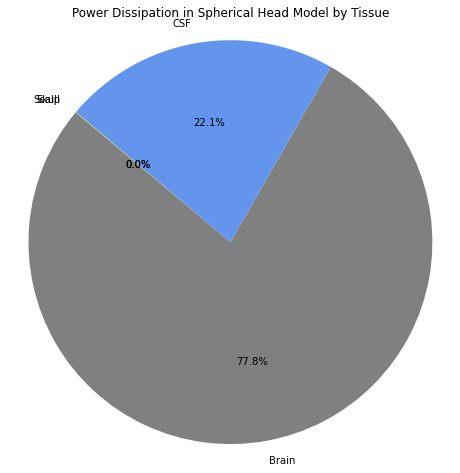

In [19]:
power_tissue_pie_chart('Power Dissipation', sphere_hm['labels'], sphere_p_els, sphere_hm_dict, 'Spherical', sphere_color)

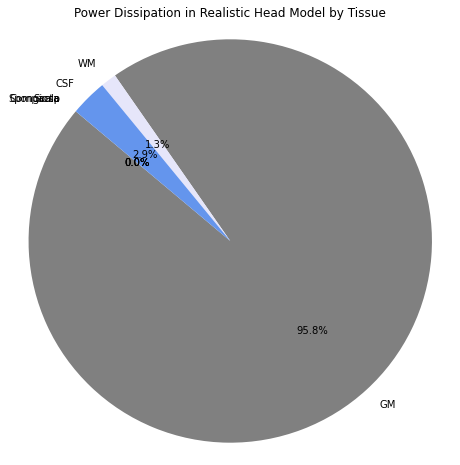

In [20]:
power_tissue_pie_chart('Power Dissipation', real_hm['labels'], real_p_els, real_hm_dict, 'Realistic', real_color)

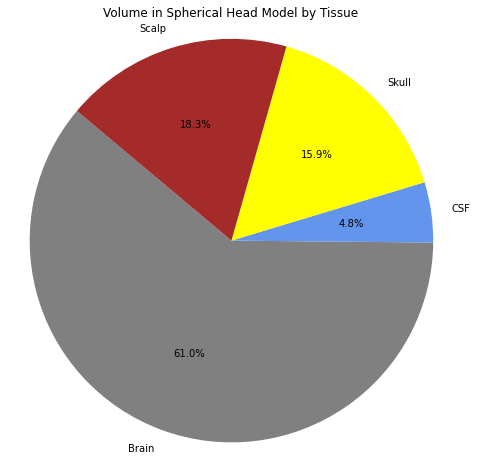

In [21]:
power_tissue_pie_chart('Volume', sphere_hm['labels'], sphere_v_els, sphere_hm_dict, 'Spherical', sphere_color)

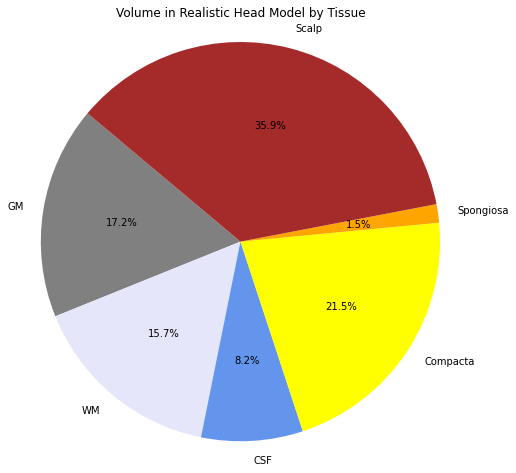

In [22]:
power_tissue_pie_chart('Volume', real_hm['labels'], real_v_els, real_hm_dict, 'Realistic', real_color)

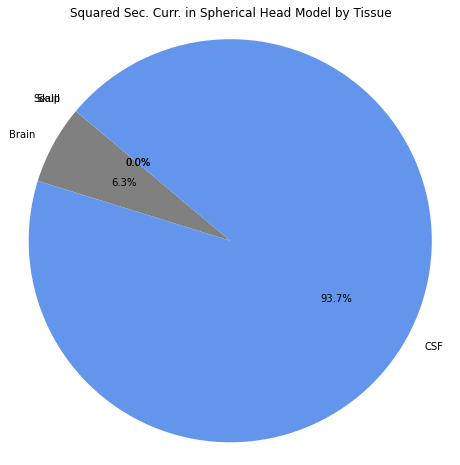

In [23]:
power_tissue_pie_chart('Squared Sec. Curr.', sphere_hm['labels'], sphere_i_sq_els, sphere_hm_dict, 'Spherical', sphere_color)

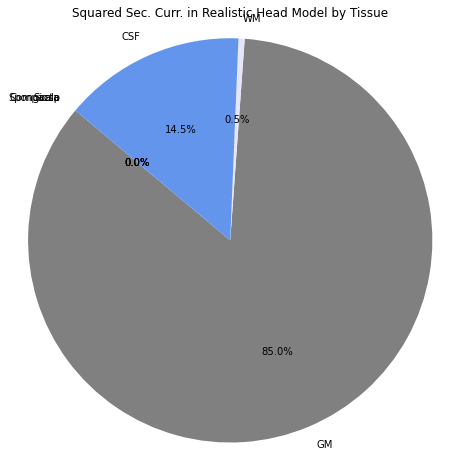

In [24]:
power_tissue_pie_chart('Squared Sec. Curr.', real_hm['labels'], real_i_sq_els, real_hm_dict, 'Realistic', real_color)

## Build a Three-Layer Empirical FEM Mesh from Brainstorm

Deviation: make sure vector sum of FEM currents is reasonable
(unit test)

In [2]:
folder="C:/Users/vik16/OneDrive/Documents/Baillet Lab/data_from_malte/mini_test/"
sec_currs=np.load(folder+"sec_currs_all_pri_dip_sub0002.npz")
print(sec_currs['sec_curr'].shape)
summed_sec_currs = np.load(folder+"summed_sec_curr_sub0002.npz")

np.sum(sec_currs['sec_curr'],0)

(3, 275848, 3)


array([[-2.46073649e-10,  2.56970101e-11,  1.25865435e-10],
       [-4.15565261e-10,  4.57209280e-10,  2.05755866e-11],
       [-8.47845191e-09,  3.78656537e-09,  6.29269009e-10],
       ...,
       [-1.43921556e-10, -8.93617714e-12, -7.31401907e-12],
       [-1.34796783e-10, -4.11530183e-12, -7.69257172e-12],
       [-1.34229321e-10, -3.72765133e-12, -7.74848910e-12]])

In [3]:
np.sum(sec_currs['sec_curr'],0) / summed_sec_currs['current_density']

array([[0.98795283, 1.11945286, 1.00328813],
       [0.99131385, 1.01703066, 1.15866041],
       [0.99984729, 1.00020478, 1.00667794],
       ...,
       [0.97893863, 0.92112522, 1.88684379],
       [0.95576615, 0.56039298, 2.00925833],
       [0.97132362, 0.69013196, 1.88586225]])

In [57]:
np.mean(np.sum(sec_currs['sec_curr'],0) / summed_sec_currs['current_density'])

1.0051411284058533

In [40]:
np.corrcoef(np.sum(sec_currs['sec_curr'],0)[:,0],summed_sec_currs['current_density'][:,0])

array([[1.        , 0.99999996],
       [0.99999996, 1.        ]])

In [41]:
np.corrcoef(np.sum(sec_currs['sec_curr'],0)[:,1],summed_sec_currs['current_density'][:,1])

array([[1.        , 0.99999995],
       [0.99999995, 1.        ]])

In [42]:
np.corrcoef(np.sum(sec_currs['sec_curr'],0)[:,2],summed_sec_currs['current_density'][:,2])

array([[1.        , 0.99999997],
       [0.99999997, 1.        ]])

In [54]:
p_output=calculate_fem_p(summed_sec_currs)

Time elapsed: 14.907635499999742


In [55]:
sum(p_output[2])

3.579934854666803e-17

Deviation over. We can use the vector sum as an input to this notebook to find the overall power consumed across the summed dipoles in the brain. And the really small number above makes sense b/c we only used 2/15,000 dipoles 

In [46]:
labels=[('brain', "GM + WM + CSF"), ('skull', 'skull'), ('scalp', 'scalp')]
import scipy.io
import numpy as np

subject_list = ['sub-0004', 'sub-0006', 'sub-0007']
#folder="C:/Users/vik16/OneDrive/Documents/Baillet Lab/"
folder='/export02/data/vikramn/brainstorm3/'
output_folder='./'mat_o_
for subject in subject_list:
    fem_mat = scipy.io.loadmat(folder+subject+"_fem_mesh.mat", squeeze_me=True)
    # Convert MATLAB data to NumPy arrays
    fem_numpy = {}
    fem_numpy['nodes'] = np.array(pd.read_csv(folder+'nodes.csv', header=None))
    fem_numpy['elements'] = np.array(pd.read_csv(folder+'elements.csv', header=None)) - 1
    fem_numpy['labels'] = np.array(pd.read_csv(folder+'labels.csv', header=None)).flatten() - 1; #switch from matlab 1-based to python 0-based indexing
    fem_numpy['conductivities'] = [0.33, 0.0042, 0.33]
    fem_numpy['label_info'] = [(0, 'brain'), (1, 'skull'), (2, 'scalp')]
    np.savez(output_folder+subject+'_vc_3layer.npz', nodes=fem_numpy['nodes'], 
             elements=fem_numpy['elements'], labels=fem_numpy['labels'], label_info=fem_numpy['label_info'], 
             conductivities=fem_numpy['conductivities'])


In [47]:
max(fem_numpy['nodes'].flatten())

0.13735

In [49]:
len(fem_numpy['elements'])

275848

In [99]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

In [103]:
closest_node(0.001*np.array([29.884, 40.4298, 98.401]), three_layer_hm['nodes'])

2407

In [105]:
three_layer_hm['labels'][2407]

0

In [106]:
three_layer_hm['nodes'][2407]

array([0.030701, 0.040204, 0.098717])

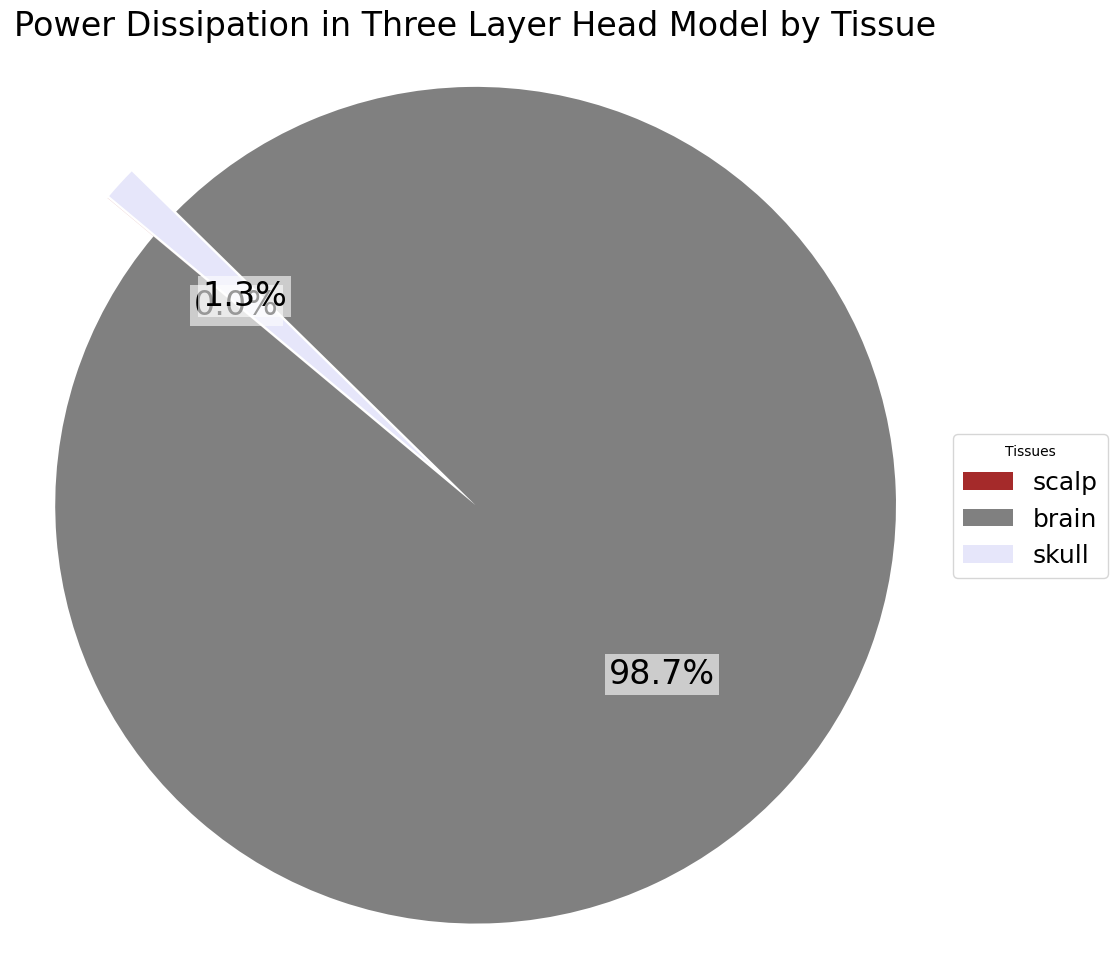

In [75]:
power_tissue_pie_chart('Power Dissipation', three_layer_hm['labels'], tl_p_els,
                       tl_hm_dict, 'Three Layer', tl_color)

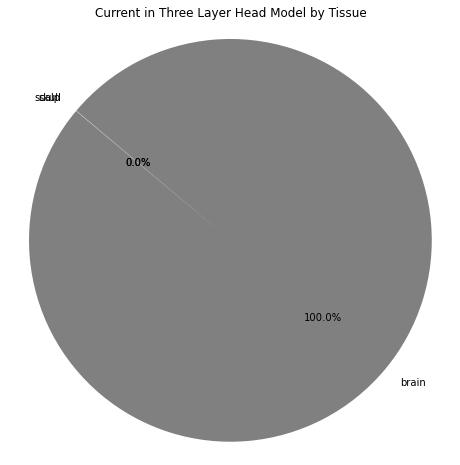

In [111]:
power_tissue_pie_chart('Current', three_layer_hm['labels'], tl_i_sq_els,
                       tl_hm_dict, 'Three Layer', tl_color)

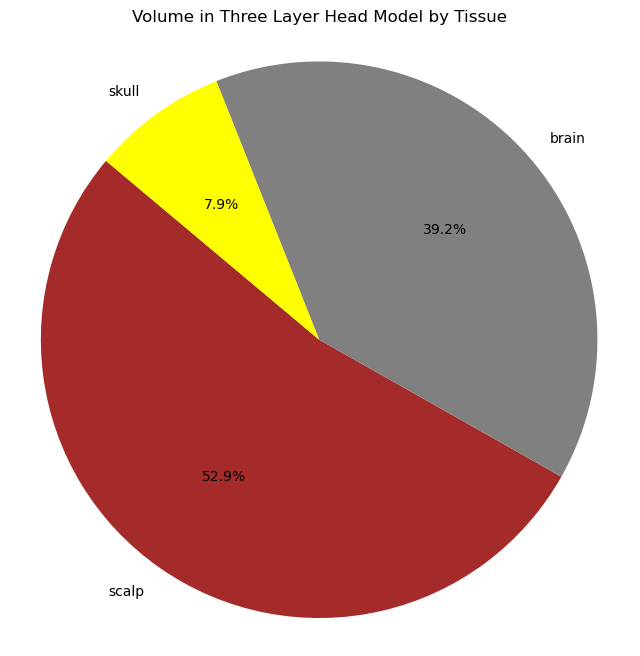

In [44]:
power_tissue_pie_chart('Volume', three_layer_hm['labels'], tl_v_els,
                       tl_hm_dict, 'Three Layer', tl_color)

In [90]:
three_layer_hm['label_info']

array([['0', 'brain'],
       ['1', 'skull'],
       ['2', 'scalp']], dtype='<U11')

## Repeat for Vector Sum of Secondary Currents

In [45]:
power_tissue_pie_chart('Power Dissipation', three_layer_hm['labels'], ss_p_els,
                       tl_hm_dict, 'Summed Secondary', tl_color)

NameError: name 'ss_p_els' is not defined

In [1]:
power_tissue_pie_chart('Secondary Currents', three_layer_hm['labels'], ss_i_sq_els,
                       tl_hm_dict, 'Summed Secondary', tl_color)

NameError: name 'power_tissue_pie_chart' is not defined

## RMS Analysis: Secondary Currents

In [37]:
#Load volume conductors with all P info
folder='C:/Users/vik16/OneDrive/Documents/Baillet Lab/data_from_malte/'

#slightly different paths for 0s and rms
sub0002_st_vc = np.load(folder+'rms_summed_sec_curr_sub-0002.npz')
sub0006_st_vc = np.load(folder+'rms_summed_sec_curr_sub-0006.npz')
sub0004_st_vc = np.load(folder+'rms_summed_sec_curr_sub-0004.npz')
sub0007_st_vc = np.load(folder+'rms_summed_sec_curr_sub-0007.npz')

#Load powers
sub0002_st_p =  np.load(folder+'rms_p_output_sub-0002.npz')
sub0006_st_p = np.load(folder+'rms_p_output_sub-0006.npz')
sub0004_st_p =  np.load(folder+'rms_p_output_sub-0004.npz')
sub0007_st_p = np.load(folder+'rms_p_output_sub-0007.npz')

In [38]:
sub0002_currents=sub0002_st_p['p_output'][1]
sub0002_powers=sub0002_st_p['p_output'][2]

sub0006_currents=sub0006_st_p['p_output'][1]
sub0006_powers=sub0006_st_p['p_output'][2]

sub0004_currents=sub0004_st_p['p_output'][1]
sub0004_powers=sub0004_st_p['p_output'][2]

sub0007_currents=sub0007_st_p['p_output'][1]
sub0007_powers=sub0007_st_p['p_output'][2]

In [18]:
sum(sub0002_powers)

2.3635073932764124e-09

In [13]:
sum(sub0004_powers)

1.7801729683168054e-09

In [14]:
sum(sub0006_powers)

9.35086414120559e-10

In [15]:
sum(sub0007_powers)

1.8214142438146955e-09

In [ ]:
###Using old function

In [9]:
import scipy
import scipy.stats as ss
sdf=ss.spearmanr([1,2,4,2],[1,2,1,5])
sdf[0]

1.0

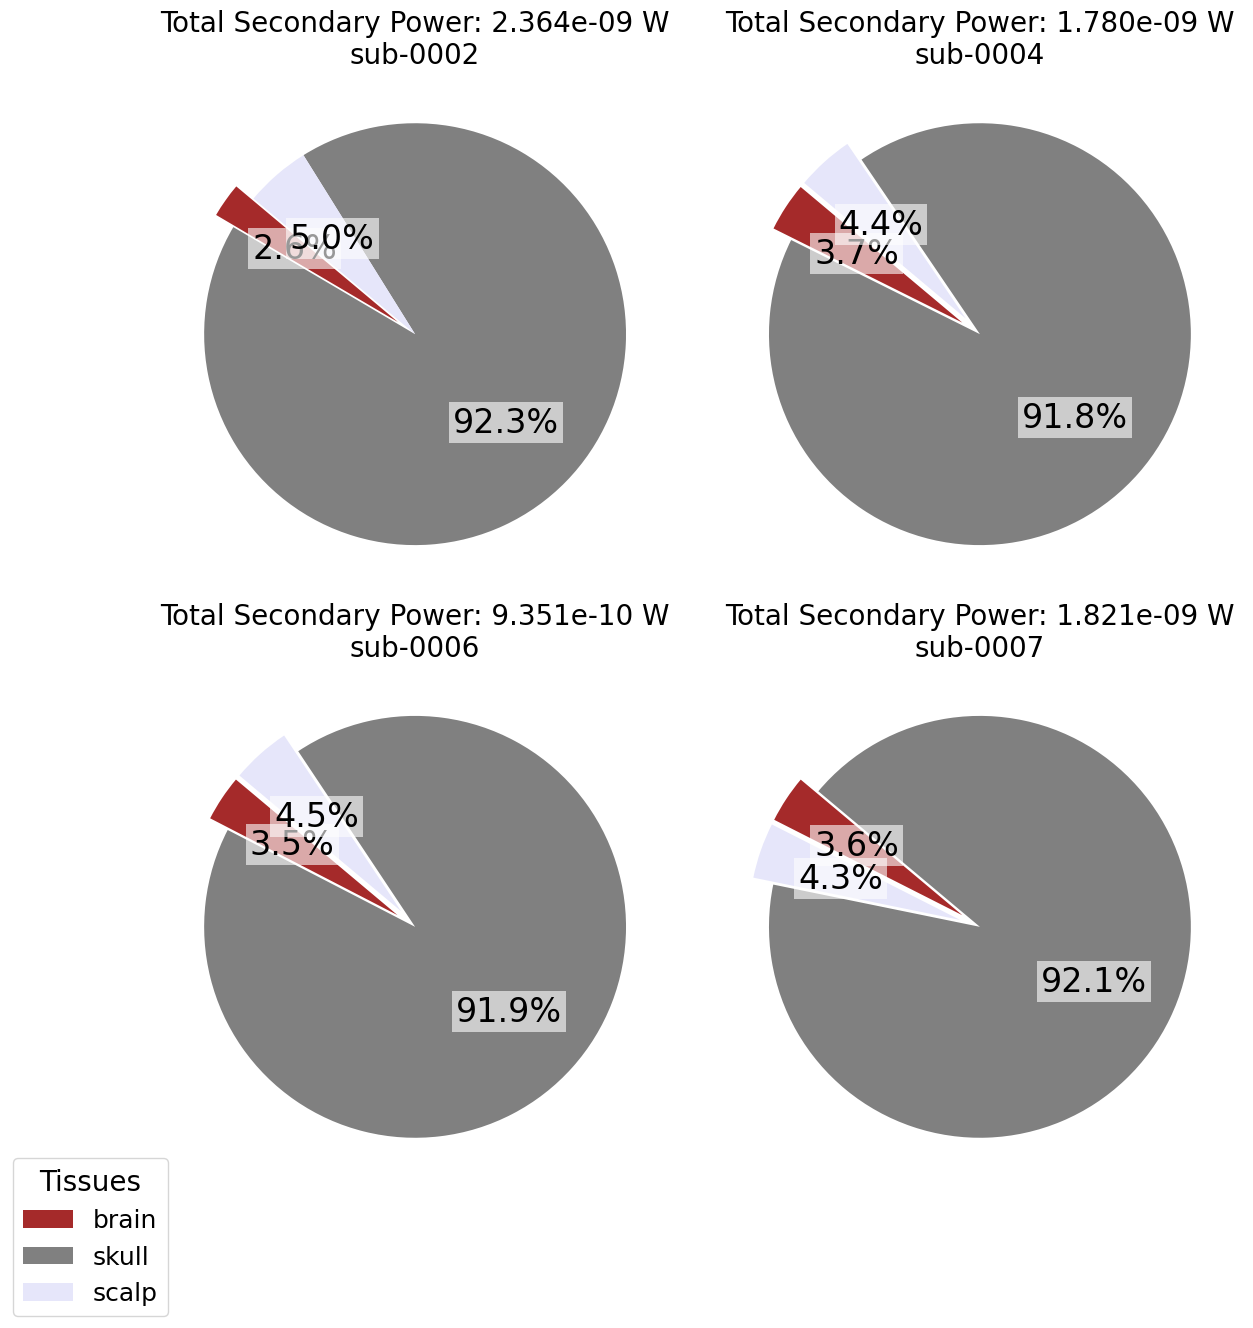

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def power_tissue_pie_chart(ax, variable, indices, data_points, hm_dict, color_map):
    """Create a pie chart on the given axes."""
    # Calculate the sum of data points for each category
    category_sums = {hm_dict[i]: 0 for i in indices}
    for i, value in enumerate(data_points):
        category_sums[hm_dict[indices[i]]] += value

    # Calculate the percentage of each category
    total_sum = sum(category_sums.values())
    percentage_data = [(label, value / total_sum * 100) for label, value in category_sums.items() if total_sum > 0]

    # Separate labels and percentages
    labels, percentages = zip(*percentage_data)

    # Calculate the explode factor to separate tiny slices
    explode = [0.1 if p < 5 else 0 for p in percentages]  # Explode small slices (under 5%)

    # Create a pie chart that fills the entire panel
    colors = [color_map[label] for label in labels]
    wedges, texts, autotexts = ax.pie(
        percentages, labels=None, autopct='%1.1f%%', startangle=140, colors=colors,
        textprops={'fontsize': 20}, explode=explode, pctdistance=0.6, radius=1.0  # Fill the panel
    )

    # Set a larger font size for the percentage numbers
    for autotext in autotexts:
        autotext.set_fontsize(24)
        autotext.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=3))

    # Set the title for the pie chart
    ax.set_title(variable, fontsize=30, loc='center', pad=10)

# Create a figure for the pie charts
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # Adjusted figure size to condense the plot
axs = axs.flatten()  # Flatten the array for easy indexing

# Create a variable to store the legend labels and handles
legend_labels = []
legend_wedges = []

# Loop through each subject and create pie charts
for i in range(4):
    # Calculate total values for titles
    total_power = np.sum(sub_powers[i])  # Total power in W
    total_current = np.sum(sub_currents[i])  # Total current in A.m
    subject_name = sub_names[i]  # Get the subject name

    # Plot Secondary Currents
    #power_tissue_pie_chart(axs[i], 'Secondary Currents', sub_vcs[i]['labels'], sub_currents[i],
    #                       tl_hm_dict, tl_color)
    #axs[i].set_title(f'Total Secondary Current: {total_current:.3e} A.m\n{subject_name}', fontsize=22, loc='center', pad=5)

    # Plot Secondary Power Dissipation
    power_tissue_pie_chart(axs[i], 'Secondary Power Dissipation', sub_vcs[i]['labels'], sub_powers[i],
                           tl_hm_dict, tl_color)
    axs[i].set_title(f'Total Secondary Power: {total_power:.3e} W\n{subject_name}', fontsize=20, loc='center', pad=5)

    # Collect the legend data from the first subplot
    if i == 0:
        for wedge in axs[i].patches:
            legend_wedges.append(wedge)
        legend_labels = list(tl_hm_dict.values())

# Add the legend only once in the bottom left corner
fig.legend(legend_wedges, legend_labels, title="Tissues", loc='lower left', fontsize=18, title_fontsize=20)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9)  # Adjust the layout further to condense the plot
plt.show()
